In [111]:
#Importing the required modules
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report

In [112]:
# Loading and preprocessing the data
streaming_data = pd.read_csv('streaming_data_fixed_quality.csv')
streaming_data['Timestamp'] = pd.to_numeric(streaming_data['Timestamp'], errors='coerce')
streaming_data['Buffer Duration'] = pd.to_numeric(streaming_data['Buffer Duration'], errors='coerce')
streaming_data['Underrun Count'] = pd.to_numeric(streaming_data['Underrun Count'], errors='coerce')
streaming_data['Underrun Duration'] = pd.to_numeric(streaming_data['Underrun Duration'], errors='coerce')
streaming_data['Network Speed'] = streaming_data['Network Speed'].str.replace(' Kbps', '').str.replace(' Mbps', '000').astype(float)

In [113]:
# Displaying the data types
print(streaming_data.dtypes)

Timestamp                 float64
Buffer Duration           float64
Current Quality            object
Underrun Count              int64
Underrun Duration           int64
Network Speed             float64
Current Bitrate (Kbps)    float64
Average Bitrate (Kbps)    float64
dtype: object


In [114]:
# Displaying the data shape
print(streaming_data.shape)


(16474, 8)


In [115]:
# Displaying the basic statistics
print(streaming_data.describe())

          Timestamp  Buffer Duration  Underrun Count  Underrun Duration  \
count  1.647400e+04     16474.000000    16474.000000       16474.000000   
mean   1.720036e+12         9.289342      131.355166         131.355166   
std    4.972888e+06         8.043564      229.239267         229.239267   
min    1.720030e+12         0.000000        0.000000           0.000000   
25%    1.720030e+12         0.040000        0.000000           0.000000   
50%    1.720040e+12        10.460000        3.000000           3.000000   
75%    1.720040e+12        15.550000      177.000000         177.000000   
max    1.720040e+12        38.560000     1140.000000        1140.000000   

       Network Speed  Current Bitrate (Kbps)  Average Bitrate (Kbps)  
count   16474.000000            16474.000000            16474.000000  
mean        9.574401              712.249784              676.308514  
std        15.554310              919.025347              878.263886  
min         0.000000               45.37

In [116]:
# Displaying the first five rows of the cleaned dataset using head function
print(streaming_data.head())

      Timestamp  Buffer Duration    Current Quality  Underrun Count  \
0  1.720030e+12            19.88  320x240 (45 kbps)               0   
1  1.720030e+12            19.03  320x240 (45 kbps)               0   
2  1.720030e+12            17.96  320x240 (45 kbps)               0   
3  1.720030e+12            16.91  320x240 (45 kbps)               0   
4  1.720030e+12            15.85  320x240 (45 kbps)               0   

   Underrun Duration  Network Speed  Current Bitrate (Kbps)  \
0                  0           7.05                   45.37   
1                  0           7.05                   45.37   
2                  0           7.05                   45.37   
3                  0           7.05                   45.37   
4                  0           7.05                   45.37   

   Average Bitrate (Kbps)  
0                   45.37  
1                   45.37  
2                   45.37  
3                   45.37  
4                   45.37  


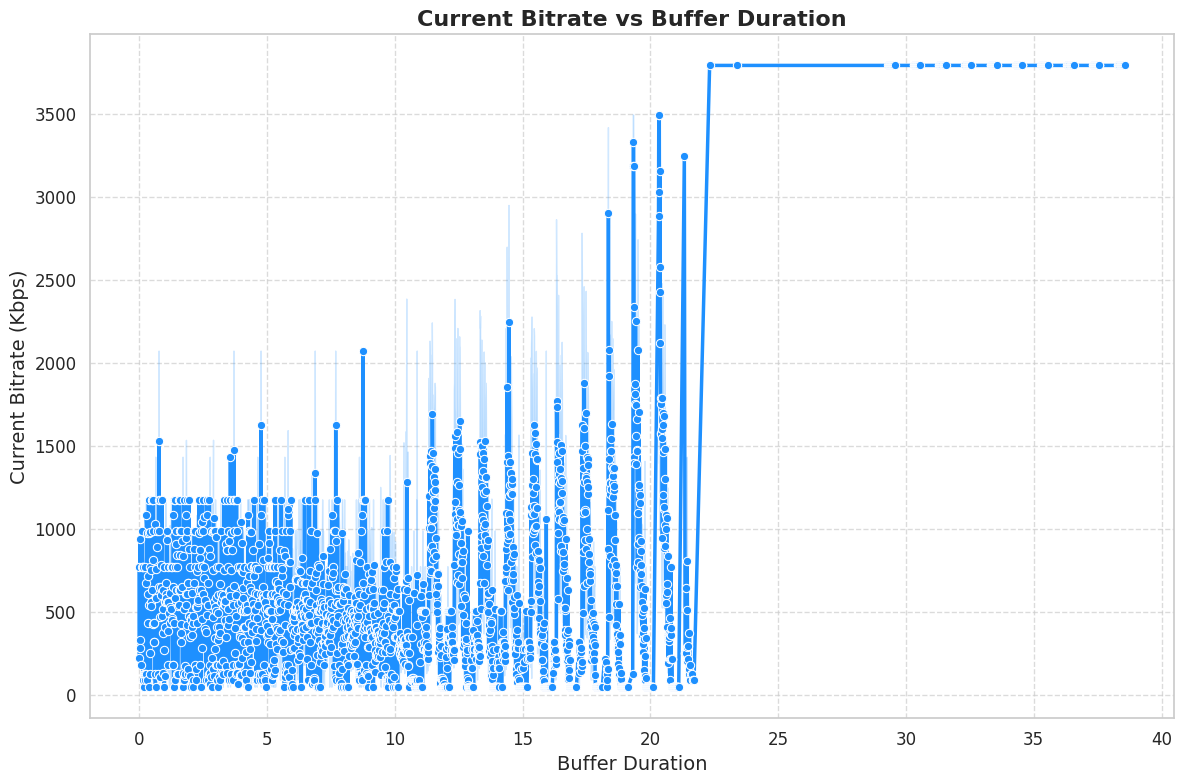

In [117]:
sns.set(style="whitegrid")

# Plotting Current Bitrate vs Buffer Duration as a line plot
plt.figure(figsize=(12, 8))
sns.lineplot(x='Buffer Duration', y='Current Bitrate (Kbps)', data=streaming_data, marker='o', color='dodgerblue', linewidth=2.5)

plt.xlabel('Buffer Duration', fontsize=14)
plt.ylabel('Current Bitrate (Kbps)', fontsize=14)
plt.title('Current Bitrate vs Buffer Duration', fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

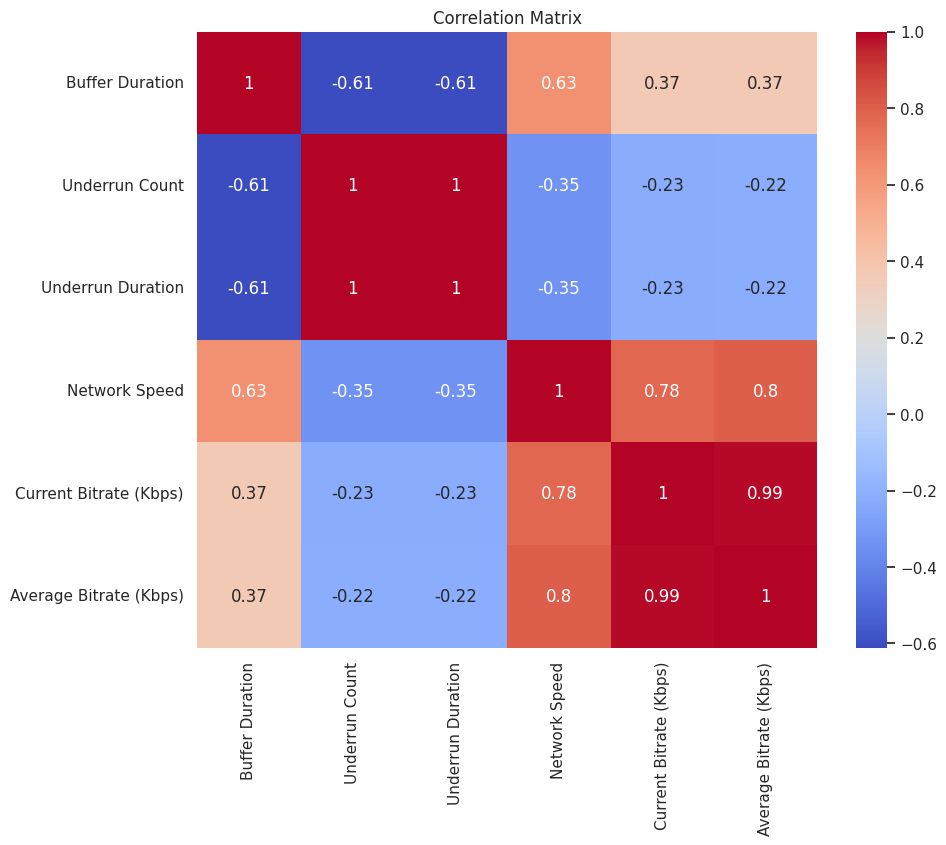

In [118]:
# Dropping the non-numeric columns for correlation calculation
numeric_df = streaming_data.drop(columns=['Current Quality', 'Timestamp'])

# Calculating the correlation matrix
corr_matrix = numeric_df.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [119]:
# Identifying unique quality levels
quality_levels = streaming_data['Current Quality'].unique()
print("\nUnique quality levels:", quality_levels)


Unique quality levels: ['320x240 (45 kbps)' '320x240 (88 kbps)' '320x240 (127 kbps)'
 '480x360 (177 kbps)' '480x360 (217 kbps)' '480x360 (253 kbps)'
 '480x360 (317 kbps)' '480x360 (369 kbps)' '854x480 (503 kbps)'
 '854x480 (569 kbps)' '1280x720 (771 kbps)' '1280x720 (987 kbps)'
 '1280x720 (1174 kbps)' '1280x720 (1431 kbps)' '1920x1080 (2071 kbps)'
 '1920x1080 (2384 kbps)' '1920x1080 (2884 kbps)' '1920x1080 (3246 kbps)'
 '1920x1080 (3494 kbps)' '1920x1080 (3792 kbps)']


In [120]:
# Encoding quality levels
label_encoder = LabelEncoder()
streaming_data['Quality_Encoded'] = label_encoder.fit_transform(streaming_data['Current Quality'])

In [121]:
# Extracting features and target for developing the model
feature_columns = ['Buffer Duration', 'Underrun Count', 'Underrun Duration', 'Network Speed']
features = streaming_data[feature_columns].values
target = streaming_data['Quality_Encoded'].values

In [122]:
# Checking for infinite or NaN values in the dataset
print("\nInfinite values in features:", np.isinf(features).sum())
print("NaN values in features:", np.isnan(features).sum())


Infinite values in features: 0
NaN values in features: 0


In [123]:
# Replace infinite values with large finite values
features = np.nan_to_num(features, nan=0, posinf=1e6, neginf=-1e6)

In [124]:
# Split the data
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [125]:
# Normalize the features
feature_scaler = StandardScaler()
features_train_scaled = feature_scaler.fit_transform(features_train)
features_test_scaled = feature_scaler.transform(features_test)

In [126]:
# Convert to PyTorch tensors
features_train_tensor = torch.FloatTensor(features_train_scaled)
features_test_tensor = torch.FloatTensor(features_test_scaled)
target_train_tensor = torch.LongTensor(target_train)
target_test_tensor = torch.LongTensor(target_test)

In [127]:
class QualityPredictionCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(QualityPredictionCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_tensor):
        input_tensor = input_tensor.unsqueeze(1)
        conv_output = self.relu(self.conv1(input_tensor))
        conv_output = self.pool(conv_output)
        conv_output = self.relu(self.conv2(conv_output))
        conv_output = self.pool(conv_output)
        flattened = conv_output.view(conv_output.size(0), -1)
        fc_output = self.relu(self.fc1(flattened))
        fc_output = self.dropout(fc_output)
        final_output = self.fc2(fc_output)
        return final_output

In [128]:
# Initializing the model
num_classes = len(quality_levels)
quality_prediction_model = QualityPredictionCNN(input_channels=1, num_classes=num_classes)

In [129]:
# Loss function and optimiser
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(quality_prediction_model.parameters(), lr=0.001)

In [136]:
# Training loop of the model
num_epochs = 50
batch_size = 32

for epoch in range(num_epochs):
    quality_prediction_model.train()
    total_loss = 0
    for i in range(0, len(features_train_tensor), batch_size):
        batch_features = features_train_tensor[i:i+batch_size]
        batch_targets = target_train_tensor[i:i+batch_size]

        outputs = quality_prediction_model(batch_features)
        loss = loss_function(outputs, batch_targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    quality_prediction_model.eval()
    with torch.no_grad():
        validation_outputs = quality_prediction_model(features_test_tensor)
        validation_loss = loss_function(validation_outputs, target_test_tensor)
        pred, predicted_labels = torch.max(validation_outputs, 1)
        accuracy = (predicted_labels == target_test_tensor).float().mean()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(features_train_tensor):.4f}, Val Loss: {validation_loss.item():.4f}, Val Accuracy: {accuracy.item():.4f}')

Epoch [10/50], Loss: 0.0368, Val Loss: 1.0548, Val Accuracy: 0.6012
Epoch [20/50], Loss: 0.0354, Val Loss: 1.0565, Val Accuracy: 0.5961
Epoch [30/50], Loss: 0.0349, Val Loss: 0.9992, Val Accuracy: 0.6446
Epoch [40/50], Loss: 0.0345, Val Loss: 1.0503, Val Accuracy: 0.5469
Epoch [50/50], Loss: 0.0360, Val Loss: 1.0231, Val Accuracy: 0.6018


In [137]:
# Saving the model to use it for prediction and integretion
model_save_path = 'quality_prediction_cnn_model.pth'
torch.save({
    'model_state_dict': quality_prediction_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'num_classes': num_classes,
    'input_channels': 1,
    'quality_levels': quality_levels.tolist(),
    'label_encoder': label_encoder,
    'feature_scaler': feature_scaler
}, model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to quality_prediction_cnn_model.pth


Final Test Accuracy: 0.6018

Classification Report:
                       precision    recall  f1-score   support

    320x240 (45 kbps)     0.7803    0.6478    0.7079       159
    320x240 (88 kbps)     0.6987    0.6301    0.6626       173
   320x240 (127 kbps)     0.5871    0.6642    0.6233       137
   480x360 (177 kbps)     0.5794    0.4336    0.4960       143
   480x360 (217 kbps)     0.5705    0.7607    0.6520       117
   480x360 (253 kbps)     0.4583    0.1833    0.2619        60
   480x360 (317 kbps)     1.0000    0.0000    0.0000        63
   480x360 (369 kbps)     0.2982    0.2833    0.2906        60
   854x480 (503 kbps)     0.3472    0.4902    0.4065        51
   854x480 (569 kbps)     1.0000    0.9831    0.9915        59
  1280x720 (771 kbps)     0.5351    0.8301    0.6508       312
  1280x720 (987 kbps)     0.6754    0.9277    0.7817       249
 1280x720 (1174 kbps)     0.6748    0.7444    0.7079       223
 1280x720 (1431 kbps)     0.8163    0.4878    0.6107       328
19

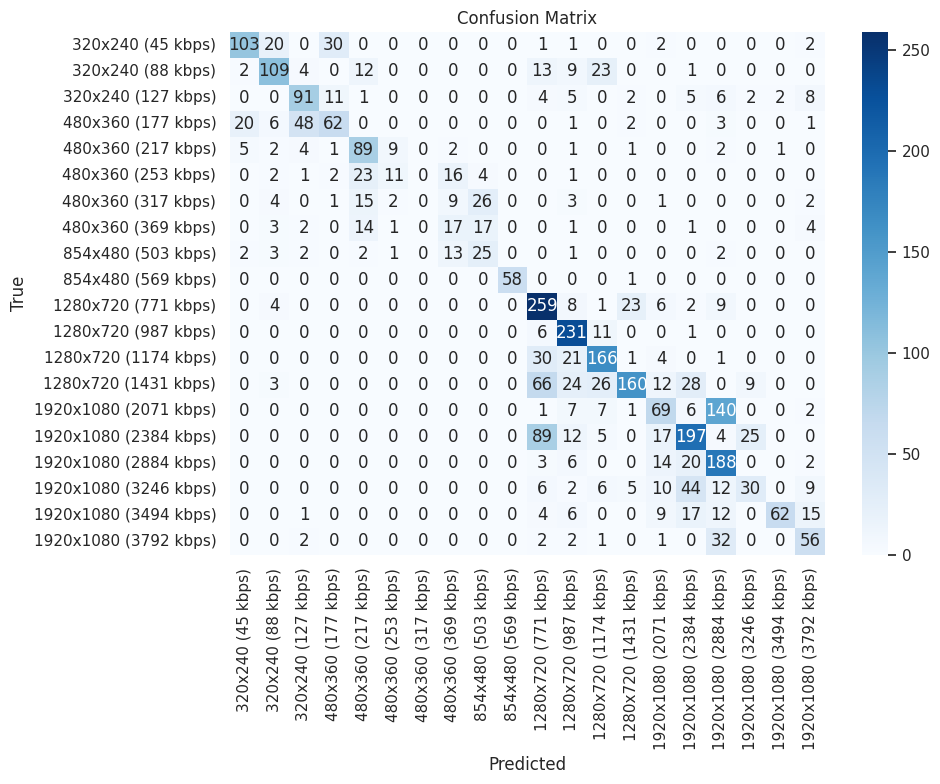

In [138]:
# Final evaluation with classification report
quality_prediction_model.eval()
with torch.no_grad():
    test_outputs = quality_prediction_model(features_test_tensor)
    pred, predicted_labels = torch.max(test_outputs, 1)
    final_accuracy = (predicted_labels == target_test_tensor).float().mean()
    print(f'Final Test Accuracy: {final_accuracy.item():.4f}')

    # Convert PyTorch tensors to numpy arrays for scikit-learn
    y_true = target_test_tensor.numpy()
    y_pred = predicted_labels.numpy()

    # Generate classification report
    class_names = [f"{quality}" for quality in quality_levels]
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=1)
    print("\nClassification Report:")
    print(report)

    # Optionally, you can also print a confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)

     # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

In [139]:
# Function to predict best quality
def predict_best_quality(buffer_duration, underrun_count, underrun_duration, network_speed):
    quality_prediction_model.eval()
    with torch.no_grad():
        input_data = np.array([[buffer_duration, underrun_count, underrun_duration, network_speed]])
        input_data_scaled = feature_scaler.transform(input_data)
        input_tensor = torch.FloatTensor(input_data_scaled)
        output = quality_prediction_model(input_tensor)
        pred, predicted_label = torch.max(output, 1)
        predicted_quality = label_encoder.inverse_transform(predicted_label.numpy())
        probabilities = torch.nn.functional.softmax(output, dim=1)
        return predicted_quality[0], probabilities.numpy()[0]

In [150]:
# Example usage
best_quality, quality_probabilities = predict_best_quality(10, 9, 38, 95.90)
print(f"Predicted best quality: {best_quality}")
print("Probabilities for each quality level:")
for quality, probability in zip(quality_levels, quality_probabilities):
    print(f"{quality}: {probability:.4f}")

Predicted best quality: 480x360 (317 kbps)
Probabilities for each quality level:
320x240 (45 kbps): 0.0000
320x240 (88 kbps): 0.0000
320x240 (127 kbps): 0.0000
480x360 (177 kbps): 0.0000
480x360 (217 kbps): 0.0000
480x360 (253 kbps): 0.0000
480x360 (317 kbps): 0.0000
480x360 (369 kbps): 0.0000
854x480 (503 kbps): 0.0000
854x480 (569 kbps): 0.0000
1280x720 (771 kbps): 0.0000
1280x720 (987 kbps): 0.0000
1280x720 (1174 kbps): 0.0000
1280x720 (1431 kbps): 0.0000
1920x1080 (2071 kbps): 0.0000
1920x1080 (2384 kbps): 0.0198
1920x1080 (2884 kbps): 0.9802
1920x1080 (3246 kbps): 0.0000
1920x1080 (3494 kbps): 0.0000
1920x1080 (3792 kbps): 0.0000
